In [1]:
# %matplotlib widget
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.axes_grid1 import make_axes_locatable
import Pyro4.util

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
expt_path=os.getcwd()+'/data'
import sys
import scipy as sp
import json

import qutip as qt
import qutip.visualization as qplt

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 16})
style.use('default')

np.set_printoptions(threshold=sys.maxsize)

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


C:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


In [3]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from PulseSequence import PulseSequence

# State tomography analysis functions

Measurement occurs along 3 axes, each of which can give one of 2 values:

Z, X, Y -> {0, 1}

In [4]:
meas_order = np.array(['Z', 'X', 'Y'])
calib_order = np.array(['g', 'e'])

## Getting rho from meas counts

First random helper method stuff for pauli matrices and dealing with the measurement order

In [5]:
def pauli(i): return [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()][i]

def s2i(s): # string to pauli matrix index
    return int(np.char.find('IXYZ', s))

def i2s(i): # pauli matrix index to string
    return 'IXYZ'[i]

def order(S): # given a pauli matrix name, get the index at which it (or equivalent data) was measured
    assert S in 'IXYZ'
    # for the purposes of getting counts, measuring in I basis and Z basis are interchangeable
    if S == 'I': S = 'Z'
    return np.argwhere(meas_order == S)[0][0]
# print(order('X'))

In [6]:
"""
Define basis in to be used when doing MLE
"""
# 2 cardinal points on Bloch sphere for each measurement axis
# psiZ = [qt.basis(3,0), qt.basis(3,1)]
psiZ = [qt.basis(2,0), qt.basis(2,1)]
psiX = [1/np.sqrt(2)*(psiZ[0]+psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-psiZ[1])]
psiY = [1/np.sqrt(2)*(psiZ[0]+1j*psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1])]
psi = dict(Z=psiZ, X=psiX, Y=psiY)

psi_basis = dict() # 6 elements
# psi_tensor = [psiZ[0], psiZ[0], psiZ[0], psiZ[0]]
for S in meas_order:
    psi0 = psi[S]
    psi_basis.update({S:[]})

    psi_basis[S].append(psi0[0]) # g
    psi_basis[S].append(psi0[1]) # e

Convert single shot measurements into counts for each of the 9 measurement axes: 4x9=36 elements in the count array, then into the initial rho from experiment which will likely be unphysical.

In [7]:
"""
n should be length 2 array containing single shot counts of measuring 0, 1 for measurement along axes i, j
Converts n to Tij for use in the T^\dag T = rho matrix where measurement axes are S: I, X, Y, Z
"""
def Tij(n, S):
    assert 0 <= S <= 3 # S1, S2 represent pauli matrix indices
    signs = [1]*2
    # eigenvalues of X, Y, Z are +/- 1, eigenvalues of I are +1
    if S > 0: signs[1] *= -1
    return np.sum(np.multiply(signs, n))


In [8]:
"""
Construct rho by adding together Tij for each of the 4 Pauli matrices
"""
def rho_from_counts(n):
    rho = 0*qt.qeye(2)
    for i in range(4): # loop over pauli matrices for qubit 1
        o = order(i2s(i)) # get the right 2 elements in the n matrix
        rho += Tij(n[2*o:2*(o+1)], i) * pauli(i)
    rho = rho.unit() # normalize
    rho = rho.tidyup(1e-10) # remove small elements
    rho = rho.full()
    return rho

### Generate test data

In [9]:
def generate_counts(qubits, rho_id, n_tot, noise=1.0):
    n = []
    for S in meas_order:
        for psi0 in psi_basis[S]:
            # measure in psi basis
            n.append(n_tot * (psi0 * psi0.dag() * rho_id).tr())
    n = np.reshape(np.array(n), (len(psi_basis.keys()), 4))

    # introduce gaussian noise
    for n_psi in n:
        n_meas = sum(n_psi)
        new_n1 = -1
        while new_n1 < 0:
            new_n0 = np.random.normal(loc=n_psi[0], scale=noise*np.sqrt(n_psi[0]))
            # preserve original total count per measurement
            new_n1 = n_meas - sum(new_n0)
        n_psi[0] = np.round(new_n0)
        n_psi[1] = np.round(new_n1)
    return n

### Error mitigation
Readout error means state prepared in |gg> will also have counts in |ge>, |eg>, |ee>; apply inverse of confusion matrix to correct. See qiskit measurement error mitigation procedure: [https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html](https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html)

maybe need to do something about fixing negative counts, but for now I will not. it should be automatically resolved in the MLE.

In [10]:
def correct_readout_err(n, n_conf):
    conf_mat = np.array(n_conf, dtype=float)
    for r, row in enumerate(conf_mat):
        conf_mat[r] /= sum(row) # normalize so counts for each state prep sum to 1
    conf_mat = np.transpose(conf_mat) # want counts for each state prep on columns
    conf_mat_inv = np.linalg.inv(conf_mat)
    # C_id = invM . C_noisy
    n = np.array(n, dtype=float)
    for r in range(len(n)):
        n[r] = (conf_mat_inv @ n[r].T).T
    return np.around(n, decimals=5)

In [11]:
def fix_neg_counts(counts):
    counts = np.array(counts)
    assert len(counts.shape) == 2 # 2d array

    for i_n, n in enumerate(counts):
        while len(n[n<0]) > 0: # repeat while still has neg counts
            assert sum(n) > 0, 'Negative sum of counts'
            neg_indices = np.where(n<0)[0]
            neg_vals = n[n<0]
            len_pos = len(n) - len(neg_vals)
            n += sum(neg_vals)/len_pos # redistribute the negative counts over all the positive elements evenly
            for i in neg_indices:
                n[i] = 0

        counts[i_n] = np.round(n)
    return counts

## Fix rho to a physical density matrix using MLE
Initial counts will be unphysical. Use MLE to map counts to a physical density matrix.

### Cholesky-esque decomposition functions

In [12]:
# Modification of np.diag_indices to allow off diagonal entries
# n = dim, k < 0 = lower diagonals, k > 0 = upper diagonals
def diag_indices_k(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0: return rows[-k:], cols[:k]
    elif k > 0: return rows[:-k], cols[k:]
    else: return rows, cols

def T_flat2mat(t):
    # T_mat = []
    # T_mat.appen(np.array([t[0],           0,              0,               0]))
    # T_mat.append(np.array([t[4] +1j*t[5],  t[1],           0,               0]))
    # T_mat.append(np.array([t[10]+1j*t[11], t[6]+1j*t[7],   t[2],            0]))
    # T_mat.append(np.array([t[14]+1j*t[15], t[12]+1j*t[13], t[8]+1j*t[9], t[3]]))
    d = int(np.sqrt(len(t)))
    t_complex = np.zeros(int(d + (len(t)-d)/2), dtype=complex)
    t_complex[:d] = t[:d]
    for i in range(d, len(t_complex)):
        t_complex[i] = t[d + (i-d)*2] + 1j*t[d + (i-d)*2 + 1]
    T_mat = np.zeros(shape=(d,d), dtype=complex)
    start_i = 0
    for k in range(d):
        T_mat[diag_indices_k(T_mat, -k)] = t_complex[start_i:start_i+(d-k)]
        start_i += d - k
    return np.array(T_mat)


Not using these!


This is taken from [James et al. 2001](https://journals.aps.org/pra/pdf/10.1103/PhysRevA.64.052312), eq. 4.6.

In [13]:
# def det_ij(rho, i, j):
#     M = np.delete(rho, i, axis=0)
#     M = np.delete(M, j, axis=1)
#     return np.linalg.det(M)

# def det_ijkl(rho, i, j, k, l):
#     M = np.delete(rho, [i,k], axis=0)
#     M = np.delete(M, [j,l], axis=1)
#     return np.linalg.det(M)

# def t_from_rho_unused(rho):
#     t = []
#     det = np.linalg.det(rho)
#     det00 = det_ij(rho, 0, 0)
#     det01 = det_ij(rho, 0, 1)
#     det0011 = det_ijkl(rho, 0, 0, 1, 1)
#     det0012 = det_ijkl(rho, 0, 0, 1, 2)
#     det0112 = det_ijkl(rho, 0, 1, 1, 2)
#     # ensure no divide by 0 errors since this algo is intended for positive definite matrices
#     if det == 0: det = 1e-10
#     if det00 == 0: det00 = 1e-10
#     if det0011 == 0: det0011 = 1e-10
#     if det0012 == 0: det0012 = 1e-10
#     if det0112 == 0: det0112 = 1e-10
#     rho33 = rho[3,3]
#     if rho33 == 0: rho33 = 1e-10
#     t = [np.sqrt(det/det00), np.sqrt(det00/det0011), np.sqrt(det0011/rho33), np.sqrt(rho[3,3])]
#     t56 = det01/np.sqrt(det00*det0011)
#     t.extend([np.real(t56), np.imag(t56)])
#     t78 = det0012/np.sqrt(rho33*det0011)
#     t.extend([np.real(t78), np.imag(t78)])
#     t910 = rho[3,2]/np.sqrt(rho33)
#     t.extend([np.real(t910), np.imag(t910)])
#     t1112 = det0112/np.sqrt(rho33*det0011)
#     t.extend([np.real(t1112), np.imag(t1112)])
#     t1314 = rho[3,1]/np.sqrt(rho33)
#     t.extend([np.real(t1314), np.imag(t1314)])
#     t1516 = rho[3,0]/np.sqrt(rho33)
#     t.extend([np.real(t1516), np.imag(t1516)])
#     assert(len(t)==16)
#     return np.real(np.array(t)) # take the real since rho may be slightly non-positive semi definite, so det(rho) may be slightly negative

# def rho_from_t_unused(t):
#     T = T_flat2mat(t)
#     rho = T.conj().T @ T
#     return rho / np.trace(rho)

Using this.

Cholesky-Banachiewicz algorithm - valid for positive definite matrices, so need to ensure no divide by 0 errors. I think this actually works better than the James et al method?

In [14]:
def t_from_rho(rho):
    t = []
    T = np.zeros(shape=np.shape(rho))
    d = np.shape(rho)[0]
    for i in range(d):
        for j in range(i+1):
            sum = 0
            for k in range(j):
                sum += T[i, k] * T[j, k]
            if i == j: T[i, i] = np.sqrt(rho[i, i] - sum)
            else:
                Tjj = T[j, j]
                if Tjj == 0: Tjj = 1e-10
                T[i, j] = (rho[i, j] - sum) / Tjj
    t = np.diagonal(T)
    for k in range(1, d):
        t_complex = np.diag(T, k=-k)
        for t_i in t_complex:
            t = np.append(t, [np.real(t_i), np.imag(t_i)])
    return np.real(t)
    
def rho_from_t(t):
    T = T_flat2mat(t)
    rho = T @ T.conj().T
    return rho / np.trace(rho)

### MLE functions

In [15]:
def run_MLE(n, rho_guess=None, method='L-BFGS-B', decimals=10):
    # methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
    if rho_guess is None: rho_guess = rho_from_counts(n)
    n_tot = sum(n)
    # psi_basis = get_psi_basis(qubits)
    psi_basis_flat = []
    for S in meas_order:
        for psi in psi_basis[S]:
            # measure in psi basis
            psi_basis_flat.append(psi)
    def likelihood(t_arr):
        rho = rho_from_t(t_arr)
        rho = rho / np.trace(rho)
        val = 0
        for psi, n_val in zip(psi_basis_flat, n.flatten()):
            psi = psi.full()
            proj = (psi.conj().T @ rho @ psi)[0][0]
            if proj != 0:
                val += np.real(abs(n_tot * proj - n_val)**2 / (n_tot * proj))
        return np.log(val)
    optvals = sp.optimize.minimize(likelihood, t_from_rho(rho_guess), method=method)
    # print(f'Convergence: {optvals.success}')
    return np.around(rho_from_t(optvals.x), decimals=decimals)

# Plotting functions

In [16]:
def show_mat_2d(mat, ax, title, labels, cmax=1, show=True):
    """
    Plot an arbitrary 2D matrix with labels
    """
    plt.sca(ax)
    plt.title(title, fontsize=18)
    plt.imshow(np.real(mat), cmap='RdBu')
    plt.xticks(np.arange(len(mat)), labels, fontsize=18)
    plt.yticks(np.arange(len(mat)), labels, fontsize=18)
    # Loop over data dimensions and create text annotations.
    for ii in range(len(mat)):
        for jj in range(len(mat)):
            plt.text(ii, jj, round(mat[jj, ii], 3), ha="center", va="center", color="w", size=22)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(cax=cax, ticks=[-cmax, 0, cmax])
    cbar.ax.tick_params(labelsize=14)
    plt.clim(vmin=-cmax, vmax=cmax)
    plt.tight_layout()
    if show: plt.show()

def show_plot_rho_2d(rho_MLE, rho_id=None, title=None, cmax=None, savetitle=None):
    """
    Plot real and imag parts of rho, optionally also with a comparison ideal rho
    """
    if savetitle is not None: plt.style.use('dark_background')
    labels = ["0", "1"]
    if rho_id is None:
        fig = plt.figure(figsize=(10, 4))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
    else:
        fig = plt.figure(figsize=(10, 8))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(223)
        ax4 = fig.add_subplot(224)
    plt.suptitle(title, fontsize=24)
    if cmax is None: cmax = np.max(np.abs(np.array([np.real(rho_MLE), np.imag(rho_MLE), np.real(rho_id), np.imag(rho_id)])))
    show_mat_2d(np.real(rho_MLE), ax=ax1, title="Re[$\\rho_{MLE}$]", labels=labels, cmax=cmax, show=False)
    show_mat_2d(np.imag(rho_MLE), ax=ax2, title="Im[$\\rho_{MLE}$]", labels=labels, cmax=cmax, show=False)
    show_mat_2d(np.real(rho_id), ax=ax3, title="Re[$\\rho_{Ideal}$]", labels=labels, cmax=cmax, show=False)
    show_mat_2d(np.imag(rho_id), ax=ax4, title="Im[$\\rho_{Ideal}$]", labels=labels, cmax=cmax, show=False)
    
    if savetitle is not None:
        plt.savefig(savetitle, format='png', bbox_inches='tight', transparent = True)
        
    plt.show()

## Virtual Z rotation optimization

In [17]:
def z_gate_1q(phi1): # expects phis in deg
    return qt.qip.operations.gates.rz(np.pi/180*phi1)

# The experimental density matrix from MLE may be offset from the simulated/ideal density matrix by a Z gate - due to different pulse times, ac stark shifts, etc.
def opt_virtualZ_MLE(rho_MLE, rho_id, phis=[None]): # phis in deg
    if phis[0] is None: phis[0] = np.linspace(0, 360, 100)
    best_fid = 0
    best_phis = [0]
    best_rho_MLE = rho_MLE
    for phi1 in tqdm(phis[0]):
        z_phi1 = z_gate_1q(phi1)
        rho_MLE_rot = (z_phi1*rho_MLE*z_phi1.dag()).unit()
        fid = qt.fidelity(rho_MLE_rot, rho_id)**2
        # print(fid)
        if fid > best_fid:
            best_fid = fid
            best_phis = [phi1]
            best_rho_MLE = rho_MLE_rot
    print(f'Improved fidelity by (%) {(best_fid - qt.fidelity(rho_MLE, rho_id)**2)*100}')
    return best_rho_MLE, best_phis, best_fid

# Run experiment and analysis

In [18]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_pi_pulse_ZZ
imported experiments.two_qubit.pulse_probe_coupling_spectroscopy


In [19]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [20]:
# expt_path = os.getcwd()+'\data'
# expt_path = 's:\\Connie\\experiments\\20220430_2Transmon\\data'
# expt_path = os.getcwd()+'\\data_220712'
# expt_path=os.getcwd()+'\data\data_221215'
# expt_path=os.getcwd()+'\data\data_230217'
expt_path=os.getcwd()+'\data\data_231212'
print('Data will be stored in', expt_path)

Data will be stored in S:\Connie\experiments\qramLL_4QR2\data\data_231212


In [21]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.getcwd() + '\\' + config_file

# config_file = 'config.yml'
# config_path = 's:\\Connie\\experiments\\20220430_2Transmon\\' + config_file

print('Config will be', config_path)

Config will be S:\Connie\experiments\qramLL_4QR2\config_q3diamond_full688and638_reset.yml


In [22]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

## Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [23]:
im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

In [24]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print('set freq to', lo_freq)
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

Default Instrument SC_26C1
set freq to 5925000000.0
set power to 15.0


In [25]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Software version: 0.2.207
	Firmware timestamp: Mon Jul 24 13:57:32 2023

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 65536 samples
		DAC tile 2, blk 0, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, blk 1, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	2:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, blk 2, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	3:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, blk 3, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC ti

## Run experiment and acquire data

### QCTRL stuff

In [ ]:
from qctrl import Qctrl
qctrl = Qctrl()

In [ ]:
ctrl_result = qctrl.get_result(action_id=1761100)
# ctrl_result = qctrl.get_result(action_id=1763052)

In [ ]:
print("Fidelity:", 1-ctrl_result.output["cost"]["value"])

times_us = []
I_values_MHz = []
Q_values_MHz = []
for q in range(4):
    if f"$\gammaI_{q}$" not in ctrl_result.output: continue
    I_values_q = []
    Q_values_q = []
    t = 0
    for j in range(2): # I, Q
        name = f"$\gamma{'I' if j==0 else 'Q'}_{q}$"
        control = ctrl_result.output[name]
        for step, pulse in enumerate(control):
            if q==1 and j==0: times_us.append(t)
            t += pulse['duration']
            # factor of 1/2, -1, and 2pi due to how their controls are defined relative to ours
            if j==0: I_values_q.append(pulse['value'])
            else: Q_values_q.append(pulse['value'])

    I_values_MHz.append(I_values_q)
    Q_values_MHz.append(Q_values_q)

times_us = np.array(times_us)*1e-3
I_values_MHz = np.array(I_values_MHz)*1e3
Q_values_MHz = np.array(Q_values_MHz)*1e3

plt.figure(figsize=(6,8))
plt.suptitle('I, Q Controls (qubit drives)', fontsize=14)
ymax = 1.1*max(abs(np.concatenate((I_values_MHz.flatten(), Q_values_MHz.flatten()))))

controls_index = 0
for q in range(4):
    if f"$\gammaI_{q}$" not in ctrl_result.output: continue
    plt.subplot(int(f'41{q+1}'))
    plt.plot(1e3*times_us, I_values_MHz[controls_index], label=f'$I_{q}$')
    plt.plot(1e3*times_us, Q_values_MHz[controls_index], label=f'$Q_{q}$')
    plt.ylim(-ymax, ymax)
    plt.ylabel(f'$\gamma_{q}/2\pi$ [MHz]')
    plt.legend()
    controls_index += 1

plt.xlabel('Times [ns]')
plt.tight_layout()
plt.show()

In [ ]:
I_mhz_vs_us = I_values_MHz[0]
Q_mhz_vs_us = Q_values_MHz[0]

ch=1
gencfg = soc['gens'][ch]
maxv = gencfg['maxv']*gencfg['maxv_scale']
samps_per_clk = gencfg['samps_per_clk']
times_cycles = soc.us2cycles(times_us, gen_ch=ch)
times_samps = samps_per_clk * times_cycles
IQ_scale = max((np.max(np.abs(I_mhz_vs_us)), np.max(np.abs(Q_mhz_vs_us))))
I_func = sp.interpolate.interp1d(times_samps, I_mhz_vs_us/IQ_scale, fill_value='extrapolate')
Q_func = sp.interpolate.interp1d(times_samps, Q_mhz_vs_us/IQ_scale, fill_value='extrapolate')
t = np.arange(0, np.round(times_samps[-1]))
iamps = I_func(t)
qamps = Q_func(t)

plt.plot(maxv*iamps)
plt.plot(maxv*qamps)

### Test 1Q tomo

In [ ]:
qubit = 0 # which qubit/resonator we want to probe

In [ ]:
tomo = meas.StateTomography1QExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"StateTomoQ{qubit}",
    config_file=config_path,
)

tomo.cfg.expt = dict(
    reps=10000, # reps per measurement basis
    singleshot_reps=10000, # reps per state for singleshot calibration
    qubit=qubit,
    # Icontrols=I_values_MHz[0],
    # Qcontrols=Q_values_MHz[0],
    # times_us=times_us,
)

print(tomo.cfg)
tomo.go(analyze=False, display=False, progress=True, save=False)

### Qram experiment

In [ ]:
qubit = 2 # which qubit/resonators to do tomo on

In [ ]:
save_data = True

In [ ]:
init_state = '|0+1>|1>' # switch, input
play_pulses = [0], # [1, 3] # [2, 1, 4, 3]

In [ ]:
saved_files = []
qramExpt = meas.QramProtocol1QTomoExperiment(
    soccfg=soc,
    path=expt_path,
    config_file=config_path,
)

span = np.inf
npts = 1
if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))

qramExpt.cfg.expt = dict(
    # start=0, # start protocol time [us],
    # step=span/npts, # time step [us], 
    # expts=npts+1, # number of different time experiments - added 1 to include 0 step and full span

    start=span,
    step=0,
    expts=1, # number of different time experiments

    reps=10000, # number of reps per tomo/time step,
    # singleshot_reps=1, # reps per state for singleshot calibration
    singleshot_reps=30000, # reps per state for singleshot calibration
    post_process='scale', # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
    qubit=qubit,
    init_state=init_state,
    play_pulses=play_pulses,
)

# print(qramExpt.cfg)

try:
    qramExpt.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

if save_data: saved_files.append(qramExpt.save_data())

In [ ]:
tomo = qramExpt

## Run analysis

In [ ]:
# data, attrs = prev_data(expt_path, '00000_EgGf_state_tomo_01.h5')
# pulse_dict = attrs['pulse_dict']
# assert np.all(np.array(attrs['meas_order']) == meas_order)
# assert np.all(np.array(attrs['calib_order']) == calib_order)

data = tomo.data
pulse_dict = tomo.pulse_dict
assert np.all(np.array(tomo.meas_order) == meas_order)
assert np.all(np.array(tomo.calib_order) == calib_order)

n_tomo = np.array(data['counts_tomo'])
n_calib = np.array(data['counts_calib'])

print('Tomography counts')
print(n_tomo)
print('Confusion matrix counts')
print(n_calib)
print('Confusion matrix corrected tomo matrix will be')
print(correct_readout_err(n_tomo, n_calib))
print('Negative counts corrected tomo matrix will be')
print(fix_neg_counts(correct_readout_err(n_tomo, n_calib)))

In [ ]:
# qubits = [qubit]
# for basis, pulse_cfgs in tqdm(pulse_dict.items()):
#     for pulse_name, pulse_cfg in pulse_cfgs.items():
#         if pulse_cfg['flag'] != 'ZZcorrection': continue
#         print(pulse_name, pulse_cfg)

Generate test data

In [ ]:
# n_tomo = generate_counts(qubits=qubits, rho_id=rho_id, n_tot=1000, noise=1)
# n_calib = qt.qeye(4).full()
# print(n_tomo)

Calculate ideal psi for fidelity calculation. Change this depending on what you want for ideal final state.

In [ ]:
# psi_id = 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1])
psi_id = (psiZ[0]+psiZ[1]).unit()
# psi_id = psiZ[1].unit()

rho_id = qt.ket2dm(psi_id)
print(rho_id)

### Run MLE without ZZ correction

In [ ]:
# methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
rho_MLE = run_MLE(n=correct_readout_err(n_tomo, n_calib), method='L-BFGS-B')
if rho_MLE is not None:
    fid_base = qt.fidelity(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
    purity_base = np.real(np.trace(rho_MLE @ rho_MLE))
    print(f'Fidelity (no ZZ correction): {fid_base}')
    print(f'Purity (no ZZ correction): {purity_base}')
print(np.around(rho_MLE, decimals=3))
show_plot_rho_2d(rho_MLE, rho_id, title=f'Base MLE (Q{qubit})', cmax=0.5)

print('Saved data:')
print(*saved_files)

### Optimize over virtual Z gates on ideal rho 

In [ ]:
def z_gate_1q(phi1): # expects phis in deg
    return qt.qip.operations.gates.rz(np.pi/180*phi1)

# The experimental density matrix from MLE may be offset from the simulated/ideal density matrix by a Z gate - due to different pulse times, ac stark shifts, etc.
def opt_virtualZ_MLE(rho_MLE, rho_id, phis=[None]): # phis in deg
    if phis[0] is None: phis[0] = np.linspace(0, 360, 100)
    best_fid = 0
    best_phis = [0]
    best_rho_MLE = rho_MLE
    for phi1 in tqdm(phis[0]):
        z_phi1 = z_gate_1q(phi1)
        rho_MLE_rot = (z_phi1*rho_MLE*z_phi1.dag()).unit()
        fid = qt.fidelity(rho_MLE_rot, rho_id)**2
        # print(fid)
        if fid > best_fid:
            best_fid = fid
            best_phis = [phi1]
            best_rho_MLE = rho_MLE_rot
    print(f'Improved fidelity by (%) {(best_fid - qt.fidelity(rho_MLE, rho_id)**2)*100}')
    return best_rho_MLE, best_phis, best_fid

In [ ]:
phis = [None]
# phis[0] = np.linspace(200, 300, 100)
rho_MLE_rot, best_phis, best_fid = opt_virtualZ_MLE(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id, phis=phis)
print('best phi', best_phis)
print('best fid', best_fid)

In [ ]:
# best_phis = [161.37931034482762, 148.9655172413793, 211.03448275862073]
z_phi1 = z_gate_1q(*best_phis)
fid_rot = qt.fidelity(rho_MLE_rot, rho_id)**2

purity_MLE = np.real(np.trace(rho_MLE @ rho_MLE))
purity_MLE_rot = np.real(np.trace(rho_MLE_rot.full() @ rho_MLE_rot.full()))
purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
print(f'Fidelity (after rotation): {fid_rot}')
print(f'Purity (after rotation): {purity_MLE_rot}')
print(f'Target purity: {purity_id}')
print(f'Best rotation: {best_phis}')

# print(np.around(rho_MLE_rot, decimals=3))
savetitle=None
show_plot_rho_2d(rho_MLE_rot, rho_id, title=f'Base MLE, Phase Optimized (Q{qubit})', savetitle=savetitle, cmax=0.5)

# Loop over 2Q sweep parameters

In [41]:
# gain_sweep = np.linspace(2000, 25000, 11)
# opt_lens = 1e3*np.array([2.4201237152470587, 1.1987019004033739, 0.7868408797215013, 0.5851160587684981, 0.4716335769416996, 0.3999234927074055, 0.34781134410506404, 0.3089041362621608, 0.2818412962269934, 0.2636215545192442, 0.2512183319921639])
# opt_freqs = [5891.5, 5891.325, 5890.9, 5890.35, 5889.675, 5888.875, 5887.95, 5887.15, 5886.1, 5885.55, 5884.5]


# gain_sweep = np.linspace(18000, 32000, 11)
# opt_freqs = [5887.35, 5886.616666666667, 5885.883333333333, 5885.616666666667, 5885.116666666667, 5884.383333333333, 5884.116666666667, 5883.616666666667, 5882.883333333333, 5882.383333333333, 5882.583333333333]
# opt_lens = [0.30514258121790533, 0.28952631508344284, 0.27703044436306967, 0.2646698856191053, 0.25368901625658447, 0.24735611563570364, 0.23874769989670325, 0.23044507614293083, 0.22816368954972915, 0.22170985331767395, 0.20962837376879714]
gain_sweep = np.linspace(15000, 32000, 21)
opt_freqs =  [5152.6, 5152.375, 5152.150000000001, 5152.125, 5151.900000000001, 5151.675, 5151.45, 5151.025000000001, 5151.2, 5150.975, 5150.75, 5150.125, 5150.5, 5150.075, 5149.450000000001, 5149.425, 5149.0, 5148.775000000001, 5148.349999999999, 5148.525000000001, 5148.1]
opt_lens = [0.4816527303797635, 0.45488217056189467, 0.43885220503674544, 0.4159844647823462, 0.3979317890180982, 0.37836130093296316, 0.36318941604519867, 0.34662914631147623, 0.3376209939250664, 0.3244724771192815, 0.31511554870772734, 0.29983590029225016, 0.28819954323748864, 0.2811511597456808, 0.2755206419978032, 0.26887588757480607, 0.259554346444521, 0.2528112077426157, 0.24498113001436106, 0.23884354213540665, 0.23269608156874075]

save_data = True
sweep2Q_q = 3
qubit = 3


psi_id = (psiZ[0]+psiZ[1]).unit()
rho_id = qt.ket2dm(psi_id)
init_state = '|0+1>|1>'
play_pulses = [2, 4] # [1, 3] # [2, 1, 4, 3]

# meas_order = None
meas_order = ['Z']

In [55]:
saved_files = []

opt_phis = [None]
thresholds = None
angles = None
ge_avgs = None
counts_calib = None

for i_gain, gain in enumerate(gain_sweep):
    
    tomo = meas.QramProtocol1QTomoExperiment(
        soccfg=soc,
        path=expt_path,
        config_file=config_path,
    )
    
    span = np.inf
    npts = 1
    if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))
    
    tomo.cfg.expt = dict(
        start=span,
        step=0,
        expts=1, # number of different time experiments
        reps=10000, # number of reps per tomo/time step,
        singleshot_reps=30000, # reps per state for singleshot calibration
        post_process='scale', # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
        qubit=qubit,
        init_state=init_state,
        play_pulses=play_pulses,
        meas_order=meas_order,
        thresholds=thresholds,
        angles=angles,
        ge_avgs=ge_avgs,
        counts_calib=counts_calib,
    )
    tomo.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q] = int(gain)
    tomo.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[sweep2Q_q] = opt_lens[i_gain]
    tomo.cfg.device.qubit.f_EgGf_Q[sweep2Q_q] = opt_freqs[i_gain]
    print('gain', tomo.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q],
          'len', tomo.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[sweep2Q_q],
          'freq', tomo.cfg.device.qubit.f_EgGf_Q[sweep2Q_q])
    try:
        tomo.go(analyze=False, display=False, progress=False, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))
    
    if save_data: saved_files.append(tomo.save_data())
    data = tomo.data
    if i_gain == 0:
        thresholds = data['thresholds']
        angles = data['angles']
        ge_avgs = data['ge_avgs']
        counts_calib = data['counts_calib']
    print()

gain 15000 len 0.4816527303797635 freq 5152.6


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

play pulses [2, 4]
playing 2
playing 4
Saving S:\Connie\experiments\qramLL_4QR2\data\data_231212\00188_QramProtocol1QTomo.h5

gain 15850 len 0.45488217056189467 freq 5152.375
Re-using provided angles, thresholds, ge_avgs, counts_calib


  0%|          | 0/1 [00:00<?, ?it/s]

play pulses [2, 4]
playing 2
playing 4
Saving S:\Connie\experiments\qramLL_4QR2\data\data_231212\00189_QramProtocol1QTomo.h5

gain 16700 len 0.43885220503674544 freq 5152.150000000001
Re-using provided angles, thresholds, ge_avgs, counts_calib


  0%|          | 0/1 [00:00<?, ?it/s]

play pulses [2, 4]
playing 2
playing 4
Saving S:\Connie\experiments\qramLL_4QR2\data\data_231212\00190_QramProtocol1QTomo.h5

gain 17550 len 0.4159844647823462 freq 5152.125
Re-using provided angles, thresholds, ge_avgs, counts_calib


  0%|          | 0/1 [00:00<?, ?it/s]

play pulses [2, 4]
playing 2
playing 4
Saving S:\Connie\experiments\qramLL_4QR2\data\data_231212\00191_QramProtocol1QTomo.h5

gain 18400 len 0.3979317890180982 freq 5151.900000000001
Re-using provided angles, thresholds, ge_avgs, counts_calib


  0%|          | 0/1 [00:00<?, ?it/s]

play pulses [2, 4]
playing 2
playing 4
Saving S:\Connie\experiments\qramLL_4QR2\data\data_231212\00192_QramProtocol1QTomo.h5

gain 19250 len 0.37836130093296316 freq 5151.675
Re-using provided angles, thresholds, ge_avgs, counts_calib


  0%|          | 0/1 [00:00<?, ?it/s]

play pulses [2, 4]
playing 2
playing 4
Saving S:\Connie\experiments\qramLL_4QR2\data\data_231212\00193_QramProtocol1QTomo.h5

gain 20100 len 0.36318941604519867 freq 5151.45
Re-using provided angles, thresholds, ge_avgs, counts_calib


  0%|          | 0/1 [00:00<?, ?it/s]

play pulses [2, 4]
playing 2
playing 4
Saving S:\Connie\experiments\qramLL_4QR2\data\data_231212\00194_QramProtocol1QTomo.h5

gain 20950 len 0.34662914631147623 freq 5151.025000000001
Re-using provided angles, thresholds, ge_avgs, counts_calib


  0%|          | 0/1 [00:00<?, ?it/s]

play pulses [2, 4]
playing 2
playing 4
Saving S:\Connie\experiments\qramLL_4QR2\data\data_231212\00195_QramProtocol1QTomo.h5

gain 21800 len 0.3376209939250664 freq 5151.2
Re-using provided angles, thresholds, ge_avgs, counts_calib


  0%|          | 0/1 [00:00<?, ?it/s]

play pulses [2, 4]
playing 2
playing 4
Saving S:\Connie\experiments\qramLL_4QR2\data\data_231212\00196_QramProtocol1QTomo.h5

gain 22650 len 0.3244724771192815 freq 5150.975
Re-using provided angles, thresholds, ge_avgs, counts_calib


  0%|          | 0/1 [00:00<?, ?it/s]

play pulses [2, 4]
playing 2
playing 4
Saving S:\Connie\experiments\qramLL_4QR2\data\data_231212\00197_QramProtocol1QTomo.h5

gain 23500 len 0.31511554870772734 freq 5150.75
Re-using provided angles, thresholds, ge_avgs, counts_calib


  0%|          | 0/1 [00:00<?, ?it/s]

play pulses [2, 4]
playing 2
playing 4
Saving S:\Connie\experiments\qramLL_4QR2\data\data_231212\00198_QramProtocol1QTomo.h5

gain 24350 len 0.29983590029225016 freq 5150.125
Re-using provided angles, thresholds, ge_avgs, counts_calib


  0%|          | 0/1 [00:00<?, ?it/s]

play pulses [2, 4]
playing 2
playing 4
Saving S:\Connie\experiments\qramLL_4QR2\data\data_231212\00199_QramProtocol1QTomo.h5

gain 25200 len 0.28819954323748864 freq 5150.5
Re-using provided angles, thresholds, ge_avgs, counts_calib


  0%|          | 0/1 [00:00<?, ?it/s]

play pulses [2, 4]
playing 2
playing 4
Saving S:\Connie\experiments\qramLL_4QR2\data\data_231212\00200_QramProtocol1QTomo.h5

gain 26050 len 0.2811511597456808 freq 5150.075
Re-using provided angles, thresholds, ge_avgs, counts_calib


  0%|          | 0/1 [00:00<?, ?it/s]

play pulses [2, 4]
playing 2
playing 4
Saving S:\Connie\experiments\qramLL_4QR2\data\data_231212\00201_QramProtocol1QTomo.h5

gain 26900 len 0.2755206419978032 freq 5149.450000000001
Re-using provided angles, thresholds, ge_avgs, counts_calib


  0%|          | 0/1 [00:00<?, ?it/s]

play pulses [2, 4]
playing 2
playing 4
Saving S:\Connie\experiments\qramLL_4QR2\data\data_231212\00202_QramProtocol1QTomo.h5

gain 27750 len 0.26887588757480607 freq 5149.425
Re-using provided angles, thresholds, ge_avgs, counts_calib


  0%|          | 0/1 [00:00<?, ?it/s]

play pulses [2, 4]
playing 2
playing 4
Saving S:\Connie\experiments\qramLL_4QR2\data\data_231212\00203_QramProtocol1QTomo.h5

gain 28600 len 0.259554346444521 freq 5149.0
Re-using provided angles, thresholds, ge_avgs, counts_calib


  0%|          | 0/1 [00:00<?, ?it/s]

play pulses [2, 4]
playing 2
playing 4
Saving S:\Connie\experiments\qramLL_4QR2\data\data_231212\00204_QramProtocol1QTomo.h5

gain 29450 len 0.2528112077426157 freq 5148.775000000001
Re-using provided angles, thresholds, ge_avgs, counts_calib


  0%|          | 0/1 [00:00<?, ?it/s]

play pulses [2, 4]
playing 2
playing 4
Saving S:\Connie\experiments\qramLL_4QR2\data\data_231212\00205_QramProtocol1QTomo.h5

gain 30300 len 0.24498113001436106 freq 5148.349999999999
Re-using provided angles, thresholds, ge_avgs, counts_calib


  0%|          | 0/1 [00:00<?, ?it/s]

play pulses [2, 4]
playing 2
playing 4
Saving S:\Connie\experiments\qramLL_4QR2\data\data_231212\00206_QramProtocol1QTomo.h5

gain 31150 len 0.23884354213540665 freq 5148.525000000001
Re-using provided angles, thresholds, ge_avgs, counts_calib


  0%|          | 0/1 [00:00<?, ?it/s]

play pulses [2, 4]
playing 2
playing 4
Saving S:\Connie\experiments\qramLL_4QR2\data\data_231212\00207_QramProtocol1QTomo.h5

gain 32000 len 0.23269608156874075 freq 5148.1
Re-using provided angles, thresholds, ge_avgs, counts_calib


  0%|          | 0/1 [00:00<?, ?it/s]

play pulses [2, 4]
playing 2
playing 4
Saving S:\Connie\experiments\qramLL_4QR2\data\data_231212\00208_QramProtocol1QTomo.h5



Replot data above

In [84]:
saved_files = []
new_opt_lens = []
start_ind = 188
file_name = '_QramProtocol1QTomo'
for i in range(len(gain_sweep)):
    ind = i+start_ind
    if ind < 10:
        saved_files.append(f's:\Connie\experiments\qramLL_4QR2\data\data_231212\\0000{ind}{file_name}.h5')
    elif ind < 100:
        saved_files.append(f's:\Connie\experiments\qramLL_4QR2\data\data_231212\\000{ind}{file_name}.h5')
    elif ind < 1000:
        saved_files.append(f's:\Connie\experiments\qramLL_4QR2\data\data_231212\\00{ind}{file_name}.h5')
print(saved_files)

['s:\\Connie\\experiments\\qramLL_4QR2\\data\\data_231212\\00188_QramProtocol1QTomo.h5', 's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_231212\\00189_QramProtocol1QTomo.h5', 's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_231212\\00190_QramProtocol1QTomo.h5', 's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_231212\\00191_QramProtocol1QTomo.h5', 's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_231212\\00192_QramProtocol1QTomo.h5', 's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_231212\\00193_QramProtocol1QTomo.h5', 's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_231212\\00194_QramProtocol1QTomo.h5', 's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_231212\\00195_QramProtocol1QTomo.h5', 's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_231212\\00196_QramProtocol1QTomo.h5', 's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_231212\\00197_QramProtocol1QTomo.h5', 's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_231212\\00198_QramProtocol1QTomo.h5', 's:\\Connie\\experiments\\qramL

### Calculate fidelities

Full density matrix fidelities with MLE with phase optimization

In [ ]:
all_n_tomo = []
all_n_calib = []
all_fids = []
all_fids_rot = []

for saved_file in saved_files:
    saved_file = saved_file.split('\\')
    # print(saved_file)
    data, attrs = prev_data(expt_path, saved_file[-1])
    assert np.all(np.array(data['meas_order']) == meas_order)
    assert np.all(np.array(data['calib_order']) == calib_order)
    pulse_dict = attrs['pulse_dict']
    n_tomo = np.array(data['counts_tomo'])
    n_calib = np.array(data['counts_calib'])

    all_n_tomo.append(n_tomo)
    all_n_calib.append(n_calib)

    rho_MLE = run_MLE(n=correct_readout_err(n_tomo, n_calib), method='L-BFGS-B')
    fid_base = qt.fidelity(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
    # show_plot_rho_2d(rho_MLE, rho_id, title=f'Base MLE (Q{qubit})', cmax=0.5)

    all_fids.append(fid_base)
    print('fid base', fid_base)
    
    rho_MLE_rot, best_phis, fid_rot = opt_virtualZ_MLE(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id, phis=opt_phis)
    all_fids_rot.append(fid_rot)
    # show_plot_rho_2d(rho_MLE_rot, rho_id, title=f'Base MLE, Phase Optimized (Q{qubit})', savetitle=None, cmax=0.5)
    print('fid rot', fid_rot)

Just the Z measurement fidelities

In [85]:
all_epop = []

for saved_file in saved_files:
    saved_file = saved_file.split('\\')
    print(saved_file[-1])
    data, attrs = prev_data(expt_path, saved_file[-1])
    assert np.array(attrs['meas_order'][0] == 'Z')
    assert np.all(np.array(attrs['calib_order']) == calib_order)
    pulse_dict = attrs['pulse_dict']
    n_tomo = np.array(data['counts_tomo'])
    n_calib = np.array(data['counts_calib'])

    n=correct_readout_err(n_tomo, n_calib)[0] # get Z measurement basis row
    epop = n[1]/sum(n)
    all_epop.append(epop)
all_epop = np.array(all_epop)

00188_QramProtocol1QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
00189_QramProtocol1QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
00190_QramProtocol1QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
00191_QramProtocol1QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
00192_QramProtocol1QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
00193_QramProtocol1QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
00194_QramProtocol1QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
00195_QramProtocol1QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
00196_QramProtocol1QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
00197_QramProtocol1QTomo.h5
Extracted

 C:\Users\slab\AppData\Local\Temp\ipykernel_24560\217307492.py: 11

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
00201_QramProtocol1QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
00202_QramProtocol1QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
00203_QramProtocol1QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
00204_QramProtocol1QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
00205_QramProtocol1QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
00206_QramProtocol1QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
00207_QramProtocol1QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
00208_QramProtocol1QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']


In [86]:
# print(all_n_tomo)
# print(all_n_calib)
# print(all_fids)
# print('fidelity with optimized rotation\n', all_fids_rot)
print('epop \n', all_epop)
print('saved files\n', saved_files)

epop 
 [0.47657128 0.46464079 0.45660067 0.47229186 0.46191752 0.48811273
 0.48577851 0.45621164 0.47747903 0.45867554 0.4651595  0.47657128
 0.44687473 0.46904988 0.50069162 0.50302585 0.52299645 0.51858736
 0.54011412 0.50341489 0.53194432]
saved files
 ['s:\\Connie\\experiments\\qramLL_4QR2\\data\\data_231212\\00188_QramProtocol1QTomo.h5', 's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_231212\\00189_QramProtocol1QTomo.h5', 's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_231212\\00190_QramProtocol1QTomo.h5', 's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_231212\\00191_QramProtocol1QTomo.h5', 's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_231212\\00192_QramProtocol1QTomo.h5', 's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_231212\\00193_QramProtocol1QTomo.h5', 's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_231212\\00194_QramProtocol1QTomo.h5', 's:\\Connie\\experiments\\qramLL_4QR2\\data\\data_231212\\00195_QramProtocol1QTomo.h5', 's:\\Connie\\experiments\\qramLL_4QR2\\

best vals:
gain: pi_EgGf_Q.gain[3] = 26900.0
len: pi_EgGf_Q.sigma[3] = 0.2755206419978032
freq: f_EgGf_Q[3] = 5149.450000000001


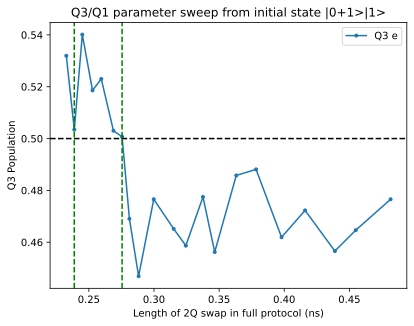

In [89]:
# plt.plot(opt_lens, all_fids_rot, label='Q2 measured fidelity')
plt.plot(opt_lens, all_epop, label=f'Q{qubit} e', marker='.')

# decay_time = 10e3 # ns
# max_fid_times = np.linspace(0, max(opt_lens), 100)
# max_fids = np.exp(-max_fid_times/decay_time)
# plt.plot(max_fid_times, max_fids, '--', label=f'{decay_time/1e3} us decay')

# decay_time = 1e3 # ns
# max_fid_times = np.linspace(0, max(opt_lens), 100)
# max_fids = np.exp(-max_fid_times/decay_time)
# plt.plot(max_fid_times, max_fids, '--', label=f'{decay_time/1e3} us decay')

best_ind = np.argmin(np.abs(all_epop-0.5))
best_len = opt_lens[best_ind]
best_freq = opt_freqs[best_ind]
best_gain = gain_sweep[best_ind]
print('best vals:')
print(f'gain: pi_EgGf_Q.gain[{sweep2Q_q}] = {best_gain}')
print(f'len: pi_EgGf_Q.sigma[{sweep2Q_q}] = {best_len}')
print(f'freq: f_EgGf_Q[{sweep2Q_q}] = {best_freq}')

plt.axhline(0.5, color='k', linestyle='--')
plt.axvline(0.2388, color='g', linestyle='--')
plt.axvline(best_len, color='g', linestyle='--')
plt.xlabel(f'Length of 2Q swap in full protocol (ns)')
plt.ylabel(f'Q{sweep2Q_q} Population')
plt.title(f'Q{sweep2Q_q}/Q1 parameter sweep from initial state {init_state}')
# plt.ylim(-0.1, 1.1)
plt.legend()
plt.show()

# Repeat over time

In [ ]:
import time

start_time = time.time()

all_n_tomo = []
all_n_calib = []
all_fids = []
times = []

psi_id = psiZ[1].unit()
rho_id = qt.ket2dm(psi_id)

while time.time() - start_time < 2*60*60:
    times.append(time.time()-start_time)
    tomo = meas.StateTomography1QExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"StateTomoQ{qubit}",
        config_file=config_path,
    )

    tomo.cfg.expt = dict(
        reps=5000, # reps per measurement basis
        qubit=qubit,
    )

    tomo.go(analyze=False, display=False, progress=False, save=False)

    data = tomo.data
    pulse_dict = tomo.pulse_dict
    assert np.all(np.array(tomo.meas_order) == meas_order)
    assert np.all(np.array(tomo.calib_order) == calib_order)

    n_tomo = np.array(data['counts_tomo'])
    n_calib = np.array(data['counts_calib'])

    all_n_tomo.append(n_tomo)
    all_n_calib.append(n_calib)

    rho_MLE = run_MLE(n=correct_readout_err(n_tomo, n_calib), method='L-BFGS-B')
    fid_base = qt.fidelity(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
    show_plot_rho_2d(rho_MLE, rho_id, title=f'Base MLE (Q{qubit})', cmax=0.5)

    all_fids.append(fid_base)
    print(fid_base)

    time.sleep(60)

In [ ]:
print(all_fids)

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(times, all_fids)
plt.xlabel('Time (s)')
plt.show()